In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Przygotowanie danych

In [ ]:
os_errors_df = pd.DataFrame({"Nr miesiąca": [i for i in range(1, 94)],
                                   "Liczba błędów": [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 9, 0, 0, 3, 1, 1, 0, 1, 0, 2, 10, 0, 16, 0, 2, 2, 1, 1, 1, 0, 3, 2, 1, 6, 3, 0, 1, 1, 0, 0, 14, 1, 4, 1, 1, 7, 14, 6, 0, 1, 2, 19, 7, 2, 5, 1, 12, 4, 6, 4, 7, 2, 2, 3, 8, 4, 6, 3, 3, 5, 8, 0, 6, 5, 10, 0, 5, 1, 2, 1, 2, 1, 0]
                                   })

In [ ]:
os_errors_df["Sb_t"] = os_errors_df["Liczba błędów"].cumsum()
t = os_errors_df["Nr miesiąca"].values
Sb_t = os_errors_df["Sb_t"].values


In [ ]:
os_errors_df

,Nr miesiąca,Liczba błędów,Sb_t
0,1,1,1
1,2,0,1
2,3,0,1
3,4,0,1
4,5,0,1
...,...,...,...
88,89,2,260
89,90,1,261
90,91,2,263
91,92,1,264


# Modelowanie

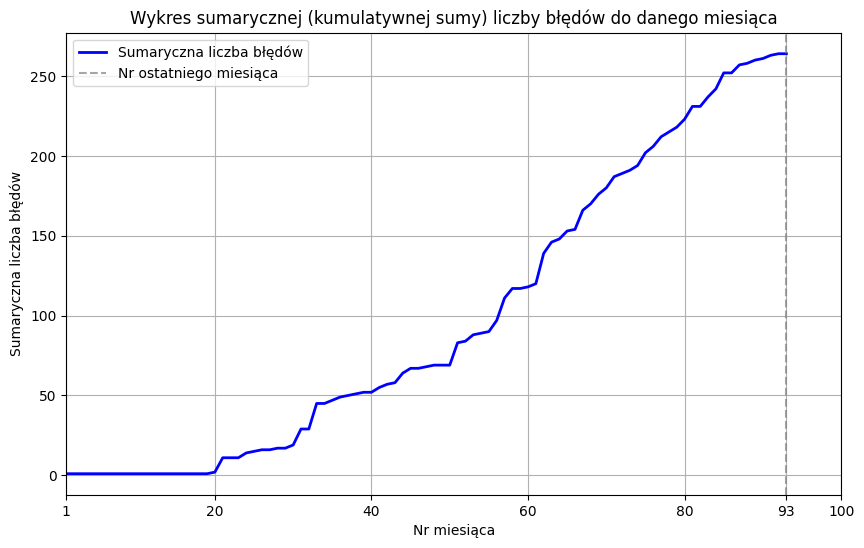

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(t, Sb_t, color='blue', linewidth=2, label='Sumaryczna liczba błędów')
plt.title('Wykres sumarycznej (kumulatywnej sumy) liczby błędów do danego miesiąca')
plt.xlabel('Nr miesiąca')
plt.ylabel('Sumaryczna liczba błędów')
plt.xlim(1, 95)
xticks = plt.xticks()[0].tolist()
xticks = [x for x in xticks if x >= 1]
if 93 not in xticks:
    xticks.append(93)
if 1 not in xticks:
    xticks.append(1)
plt.xticks(xticks)
plt.axvline(93, linestyle='--', color='gray', alpha=0.7, label='Nr ostatniego miesiąca')
plt.legend()
plt.grid(True)
plt.show()

**Obserwacje:** Jak widać po wykresie oraz analizie sumarycznej liczby błędów krytycznych wykazuje charakterystyczny przebieg (S). W początkowej fazie eksploatacji (do ok. 20. miesiąca) przyrost błędów jest bardzo mały, znikomy, co sugeruje fazę wstępnej ekspolatacji systemu. Następnie obserwujemy gwałtowny wzrost dynamiki wykrywania usterek, co sugeruje fazę aktywnego użytkowania oprogramowania. Pod koniec badanego okresu krzywa wyraźnie wykazuje tendencję do nasycenia (wypłaszczania się), co oznacza, że tempo wykrywania nowych błędów spada. Uzasadnione jest zatem użycie modelu logistycznego.

In [ ]:
def logistic_function(t, K, a, t0):
  return K / (1 + np.exp(-a * (t - t0)))

def calculate_r_squared(func, y):
  return 1 - (np.sum((y - func) ** 2) / np.sum((y - np.mean(y)) ** 2))

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
p0 = [max(Sb_t), 0.1, np.median(t)]

popt, pcov = curve_fit(logistic_function, t, Sb_t, p0 = p0)
K_opt, a_opt, t0_opt = popt

print(f"Parametry modelu:\nK (nasycenie) = {K_opt}\na (tempo wzrostu) = {a_opt}\nt0 (punkt przegięcia) = {t0_opt}")

Parametry modelu:
K (nasycenie) = 310.38316995736824
a (tempo wzrostu) = 0.0686808672917235
t0 (punkt przegięcia) = 65.73225117014748


In [ ]:
print(f"R^2: {calculate_r_squared(logistic_function(t, *popt), Sb_t)}")

R^2: 0.9955850868869721


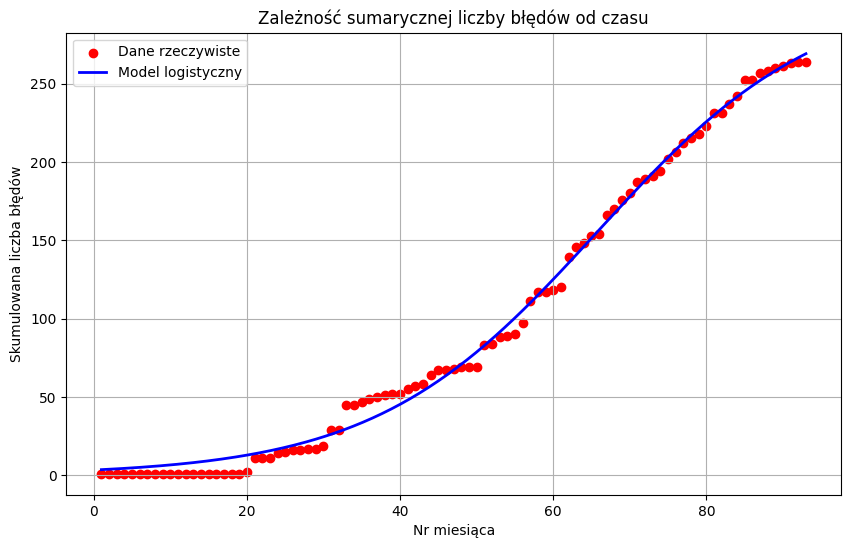

In [ ]:
t_smooth = np.linspace(min(t), max(t), 300)
plt.figure(figsize=(10, 6))
plt.scatter(t, Sb_t, color='red', label='Dane rzeczywiste')
plt.plot(t_smooth, logistic_function(t_smooth, *popt), color='blue', linewidth=2, label='Model logistyczny')
plt.title('Zależność sumarycznej liczby błędów od czasu')
plt.xlabel('Nr miesiąca')
plt.ylabel('Skumulowana liczba błędów')
plt.legend()
plt.grid(True)
plt.show()

**Obserwacje:** Nasz model logistyczny bardzo dobrze opisuje proces wykrywania błędów w badanym systemie operacyjnym, świadczy o tym współczynnik determinacji R^2 równy ok. 99,6%, co świadczy o tym, że model wyjaśnia prawie 99.6% zmienności danych. Krzywa praktycznie idealnie pokrywa się z danymi.

Parametr nasycenia K wynosi ok. 310.38. Oznacza to, że teoretyczna, całkowita sumaryczna liczba błędów krytycznych, które mogą wystąpić w okresie eksploatacji SO, wynosi około 310. Biorąc pod uwagę, że w ciągu 93 miesięcy eksploatacji wykryto dotychczas 264 błędy, można wnioskować, że wykryto około 85% wszystkich przewidywanych błędów krytycznych.

Punkt przegięcia t0 wynosi ok. 65.73, co odpowiada końcowi 65. miesiąca eksploatacji SO. Jest to moment w cyklu życia oprogramowania, w którym dynamika przyrostu nowych błędów była największa. Po przekroczeniu tego miesiąca, tempo wykrywania kolejnych błędów krytycznych zaczęło stopniowo maleć, co na wykresie objawia się przejściem krzywej w fazę wypłaszczania

Parametr a wynosi 0.069, co odzwierciedla umiarkowane tempo wzrostu sumarycznej liczby błędów. Ta wartość wskazuje na stabilny i dość długofalowy proces pojawiania się błędów oprogramowania w czasie jego eksploatacji.

Proces pojawiania się błędów w oprogramowaniu badanego systemu operacyjnego przebiega zgodnie z modelem logistycznym (krzywą w kształcie S). Początkowy powolny wzrost, następna faza intensywnego występowania błędów oraz końcowe wygasanie trendu wzrostowego są typowe dla produktów informatycznych. Choć system zbliża się do fazy nasycenia, parametr K sugeruje, że proces utrzymania powinien być kontynuowany, gdyż system nie osiągnął jeszcze pełnego, teoretycznego poziomu bezawaryjności - nie osiągnął teoretycznej liczby błędów.

https://www.youtube.com/watch?v=pNE1ufDXNSc&t=3s